## Titanic ML

In this Kaggle competition we have data on Titanic passengers and are trying to predict whether or not they survived the sinking. The 'train.csv' set has a column 'Survived' to indicate as such. From this we'll want to train a model to predict the survival outcomes of passengers in the 'test.csv' set.

First we'll load the data go over it column by column, doing some EDA and cleaning/prepping/modifying the data as necessary. Then we'll load, train, and tweak a model to predict survival.

1. [Importing the data & first look](#import)

    1.1 [Pclass](#pclass)
    
    1.2 [Name](#name)
    
    1.3 [Sex](#sex)
    
    1.4 [Age](#age)
    
    1.5 [SibSp & Parch](#family)
    
    1.6 [Ticket](#ticket)
    
    1.7 [Fare](#fare)
    
    1.8 [Cabin](#cabin)
    
    1.9 [Embarked](#embarked)
    
2. [Data encoding](#encoding)
3. [Model training](#modeling)

In [1]:
# Package imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

%matplotlib inline 

## <a name="import">Importing the data & first look</a>

In [2]:
# grab data

dt_train_raw = pd.read_csv('train.csv')
dt_test_raw = pd.read_csv('test.csv')

In [3]:
# Quick examination

dt_train_raw.sample(5)  

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
292,293,0,2,"Levy, Mr. Rene Jacques",male,36.0,0,0,SC/Paris 2163,12.8750,D,C
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S
60,61,0,3,"Sirayanian, Mr. Orsen",male,22.0,0,0,2669,7.2292,NaN,C
121,122,0,3,"Moore, Mr. Leonard Charles",male,NaN,0,0,A4. 54510,8.0500,NaN,S
432,433,1,2,"Louch, Mrs. Charles Alexander (Alice Adelaide ...",female,42.0,1,0,SC/AH 3085,26.0000,NaN,S


In [4]:
dt_train_raw.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
dt_test_raw.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


From the get go, it's probably a safe bet that survival rates going to be heavily correlated with passenger class, sex, and age, given what we all probably remember from David Cameron's totally-accurate documentary from the 90s. 

There are 891 entries in the train set and 418 in the test set. How many empty/NaN entires are there?

In [6]:
# checking for NaNs

cols = dt_train_raw.columns.drop('Survived')

print('NaNs in train set:')
for col in cols:
    val = sum(dt_train_raw[col].isnull())
    print(col, ': ', val)
    
print('NaNs in test set:')
for col in cols:
    val = sum(dt_test_raw[col].isnull())
    print(col, ': ', val) 

NaNs in train set:
PassengerId :  0
Pclass :  0
Name :  0
Sex :  0
Age :  177
SibSp :  0
Parch :  0
Ticket :  0
Fare :  0
Cabin :  687
Embarked :  2
NaNs in test set:
PassengerId :  0
Pclass :  0
Name :  0
Sex :  0
Age :  86
SibSp :  0
Parch :  0
Ticket :  0
Fare :  1
Cabin :  327
Embarked :  0


There are lots of empty entries in the 'Cabin' and 'Age' columns that we'll need to be mindful of as we proceed. 

## <a name="pclass">Pclass</a>

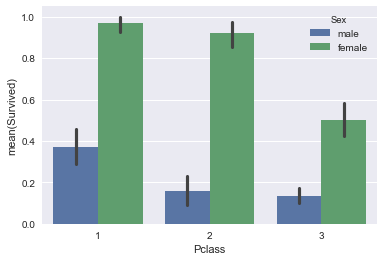

In [7]:
# Survival rates by Pclass, for men and women

sns.barplot(x='Pclass', y='Survived', hue='Sex', data=dt_train_raw)

No surprises here, given our initial assumptions: passengers are much more likely to have survived if they were 1) women, 2) in 1st class (or in 1st/2nd classes for women). 

There is not really anything we need to do to the data in this column, so let's move on.

## <a name="name">Name</a>

In [8]:
dt_train_raw.Name.sample(20)

555                                   Wright, Mr. George
429                   Pickard, Mr. Berk (Berk Trembisky)
96                             Goldschmidt, Mr. George B
53     Faunthorpe, Mrs. Lizzie (Elizabeth Anne Wilkin...
755                            Hamalainen, Master. Viljo
762                                Barah, Mr. Hanna Assi
596                           Leitch, Miss. Jessie Wills
407                       Richards, Master. William Rowe
738                                   Ivanoff, Mr. Kanio
592                           Elsbury, Mr. William James
67                              Crease, Mr. Ernest James
791                                  Gaskell, Mr. Alfred
218                                Bazzani, Miss. Albina
565                                 Davies, Mr. Alfred J
170                            Van der hoef, Mr. Wyckoff
843                           Lemberopolous, Mr. Peter L
21                                 Beesley, Mr. Lawrence
530                            

Luckily for us, the names are all consistently formatted. 

It's probably a safe bet to go ahead and assume that the passengers' last names and name prefixes (i.e. Mr, Mrs, etc) are the most important features here, so we'll go ahead parse these.

In [9]:
# I like to make a copy of the 'raw' data before doing modifications.

dt_train = dt_train_raw
dt_test = dt_test_raw

In [10]:
# Take last name and prefix from the passenger names, drop the rest

dt_train['Last_name'] = dt_train.Name.apply(lambda x: x.split(', ')[0])
dt_train['Name_prefix'] = dt_train.Name.apply(lambda x: x.split(', ')[1].split(' ')[0]) 

dt_test['Last_name'] = dt_test.Name.apply(lambda x: x.split(', ')[0])
dt_test['Name_prefix'] = dt_test.Name.apply(lambda x: x.split(', ')[1].split(' ')[0])

dt_train = dt_train.drop('Name', axis=1)
dt_test = dt_test.drop('Name', axis=1)

dt_train.sample(3)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Last_name,Name_prefix
315,316,1,3,female,26.00,0,0,347470,7.8542,NaN,S,Nilsson,Miss.
831,832,1,2,male,0.83,1,1,29106,18.7500,NaN,S,Richards,Master.
197,198,0,3,male,42.00,0,1,4579,8.4042,NaN,S,Olsen,Mr.


What are the unique name prefixes in the entire train+test set?

In [11]:
# Examine prefixes 

prefixes = pd.concat([dt_train['Name_prefix'], dt_test['Name_prefix']])
prefixes.value_counts()

Mr.          757
Miss.        260
Mrs.         197
Master.       61
Rev.           8
Dr.            8
Col.           4
Mlle.          2
Ms.            2
Major.         2
the            1
Capt.          1
Jonkheer.      1
Sir.           1
Dona.          1
Lady.          1
Don.           1
Mme.           1
Name: Name_prefix, dtype: int64

Mr, Miss, and Mrs are all probably obvious to English speaking folks. 

Mlle. is the French equivalent of Miss. , so we can substitute it to reduce dimensionality. Ms. can also be substituted with Miss.

Mme. can be substituted with Mrs.

Col., Major., and Capt. can all be folded into an 'Officer' title. 

Sir, Jonkheer, Dona, Lady, 'the', and Don are all honorific/nobility titles. We'll separate them by male and female honorifics. 

Rev. and Dr. are positions of relative esteem, so we'll combine those as well. 

Finally: 'Master' supposedly refers to young boys, specifically, according to Google (which is not what I would have expected). Let's verify this:

In [12]:
dt_train.Age.loc[(dt_train.Name_prefix=='Master.')].describe()

count    36.000000
mean      4.574167
std       3.619872
min       0.420000
25%       1.000000
50%       3.500000
75%       8.000000
max      12.000000
Name: Age, dtype: float64

In [13]:
dt_test.Age.loc[(dt_test.Name_prefix=='Master.')].describe()

count    17.000000
mean      7.406471
std       4.672470
min       0.330000
25%       5.000000
50%       7.000000
75%      11.500000
max      14.500000
Name: Age, dtype: float64

In [14]:
dt_train.Sex.loc[(dt_train.Name_prefix=='Master.')].value_counts()

male    40
Name: Sex, dtype: int64

In [15]:
dt_test.Sex.loc[(dt_test.Name_prefix=='Master.')].value_counts()

male    21
Name: Sex, dtype: int64

... so yes, 'Master' does refer to boys under the age of 14 or so exclusively, which will be useful to know when we are filling in missing Age values later.

Now let's combine the various name prefixes in the manner discussed above:

In [16]:
# prefix dict:

prefixes = {
    'Mr.' : 'Mr',
    'Mrs.' : 'Mrs', 
    'Miss.' : 'Miss', 
    'Master.' : 'Master', 
    'Don.' : 'NobleM',    # i.e. 'Male Nobility' 
    'Rev.' : 'RevDr',     
    'Dr.' : 'RevDr',      # lump Rev and Dr together
    'Mme.' : 'Mrs',
    'Ms.' : 'Miss', 
    'Major.' : 'Officer', 
    'Lady.' : 'NobleF', 
    'Sir.' : 'NobleM',    # i.e. 'Female Nobility" 
    'Mlle.' : 'Miss', 
    'Col.' : 'Officer', 
    'Capt.' : 'Officer', 
    'the' : 'NobleF',     # If you inspect the 'the' entry you will see a full title 'the Countess of...'
    'Jonkheer.' : 'NobleM',
    'Dona.' : 'NobleF'
}

In [17]:
# Replace the name prefixes per the dict. above

dt_train['Name_prefix'] = dt_train['Name_prefix'].apply(lambda x: prefixes[x])
dt_test['Name_prefix'] = dt_test['Name_prefix'].apply(lambda x: prefixes[x])

In [18]:
dt_train.Name_prefix.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'NobleM', 'RevDr', 'Officer',
       'NobleF'], dtype=object)

I am curious what the passenger Sex breakdown looks like for Revs/Drs and Officers, since they are not otherwise implied: 

In [19]:
print( dt_train.Sex.loc[(dt_train.Name_prefix=='RevDr')].value_counts() )
print( dt_train.Sex.loc[(dt_train.Name_prefix=='Officer')].value_counts() )

male      12
female     1
Name: Sex, dtype: int64
male    5
Name: Sex, dtype: int64


... so for the sake of discussion, Revs, Drs, and Officers are almost exclusively men. 

What do survival rates look like when sorted by Prefix?

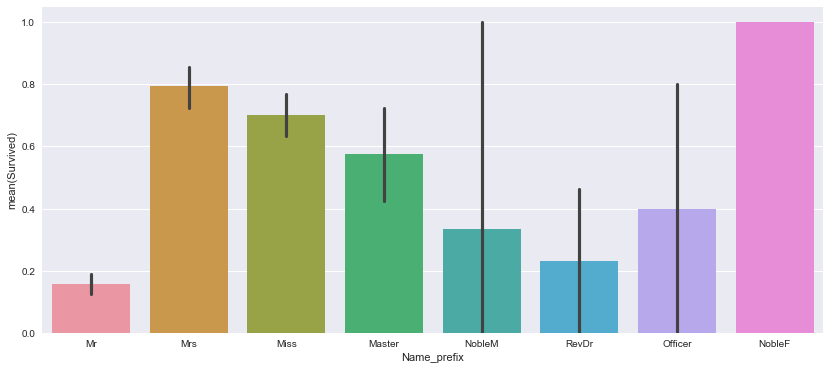

In [20]:
# Survival rates by Name Prefix

plt.subplots(1,1,figsize=(14,6))
sns.barplot(x='Name_prefix', y='Survived', data=dt_train)

Clearly we can see that among males, it was useful to have been a boy (Master), someone of status (NobleM), or a military Officer. 

## <a name="sex">Sex</a>

We already have a good intuition for survival odds by Sex:

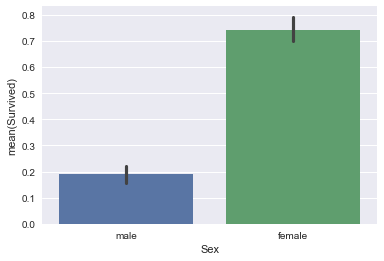

In [21]:
# Survival rates by Sex

sns.barplot(x='Sex', y='Survived', data=dt_train)

... women were substantially more likely to survive than men, as we have seen.

There is not much more that needs to be done to the data in this column.

## <a name="Age">Age</a>

We already have a good intuition that passenger Age will have a significant effect on their survival odds. We'll have some work to do in this column to fill in all of the missing values in a meaningful way. Simply taking the mean or median won't really cut it.

First off, though: Let's look at survival rates by age, separated by old school gender, just to get a feel for things:

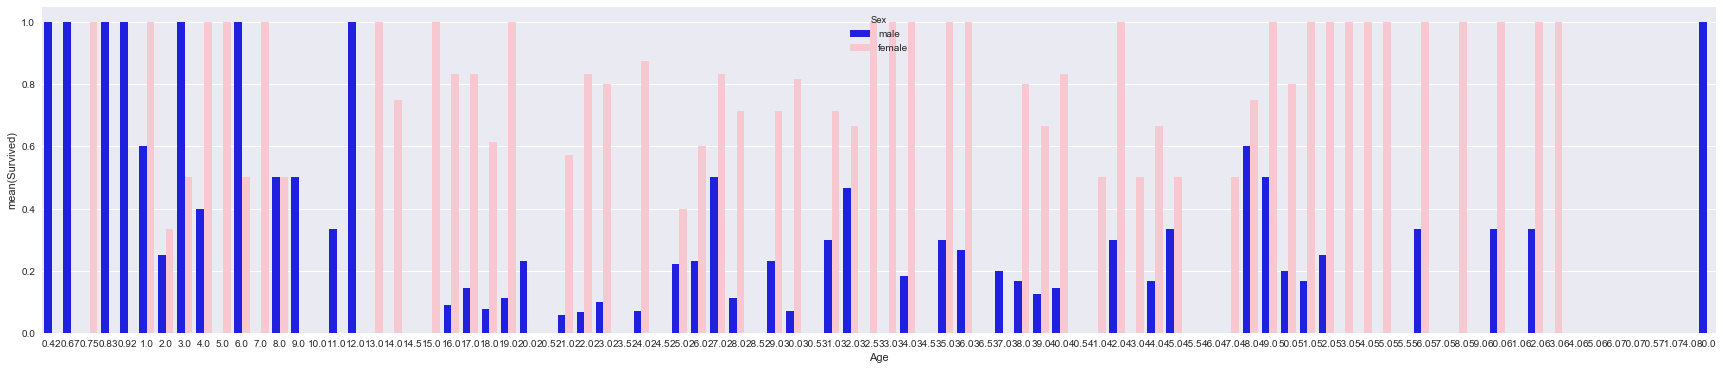

In [22]:
plt.subplots(1,1,figsize=(30,6))
sns.barplot(x="Age", y="Survived", hue='Sex', data=dt_train,
              palette={"male": "blue", "female": "pink"}, ci=None);

Clearly, survival rates for men drops off rapidly beyond the age of 12 or so. 

For women, survival rates generally dip between the ages of 13 and 50 and seem to be best beyond of 50. Within this middle range, women who are 32-36 seem to have better odds than the rest--maybe this is a typical age for mothers accompanying children onto the lifeboats?

Let's work on filling in the missing entries. We would like to use other data on these passengers to try and infer their age (at least to a best guess). 

Odds are that passenger ages are correlated to their Name Prefix (i.e. we already know that 'Master' is for boys, and it's probable that Nobility are older folks, etc). There are probably similar correlations for Pclass, Sex, etc. Let's explore a bit:

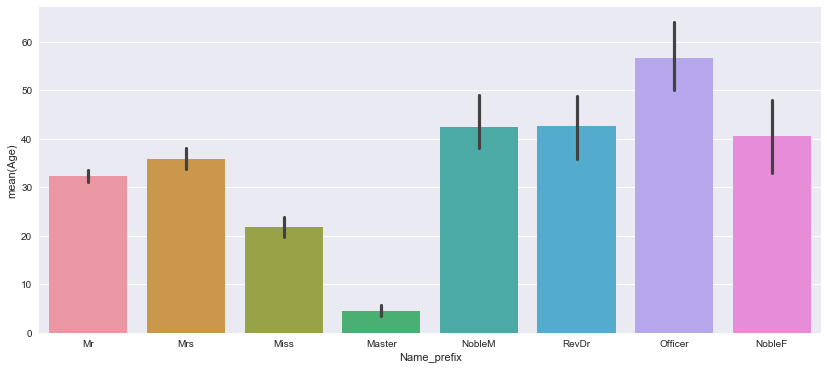

In [23]:
# Ages per Name Prefix

plt.subplots(1,1,figsize=(14,6))
sns.barplot(x="Name_prefix", y="Age", data=dt_train);

This is a good start. Can we break it down even more?

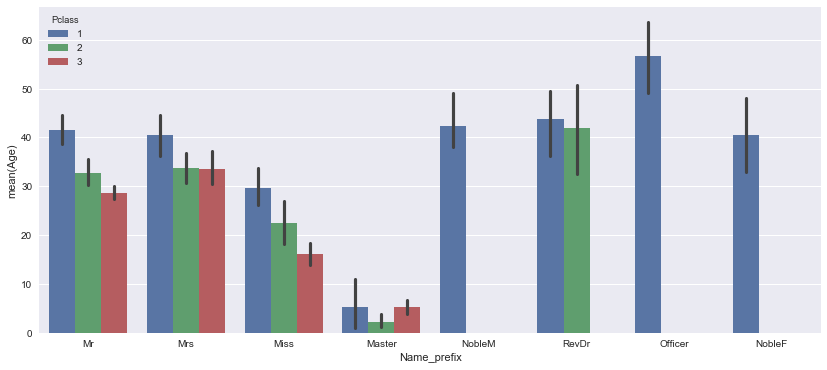

In [24]:
# Ages per Name Prefix, sorted by Pclass

plt.subplots(1,1,figsize=(14,6))
sns.barplot(x="Name_prefix", y="Age", hue="Pclass", data=dt_train);

Since all of our Name Prefixes already account for passenger Sex pretty thoroughly, it would be redundant to break the ages down further by Sex. 

This should be sufficient detail then for filling in the missing ages. If we aren't satisfied with our model's accuracy later, we can reconsider a more in-depth breakdown of ages (i.e. considering things like Fare or Cabin which may indicate wealth, and therefore perhaps correlate with Age... etc). 

In [25]:
# Median ages sorted by Pclass and Name Prefix:

dt_train.groupby(['Pclass', 'Name_prefix' ]).Age.median()

Pclass  Name_prefix
1       Master          4.0
        Miss           30.0
        Mr             40.0
        Mrs            40.0
        NobleF         40.5
        NobleM         40.0
        Officer        56.0
        RevDr          46.5
2       Master          1.0
        Miss           24.0
        Mr             31.0
        Mrs            32.0
        RevDr          46.5
3       Master          4.0
        Miss           18.0
        Mr             26.0
        Mrs            31.0
Name: Age, dtype: float64

In [26]:
# Apply median ages to NaN values:

dt_train.Age = dt_train.groupby(['Pclass', 'Name_prefix' ]).Age.apply(lambda x: x.fillna( x.median())  )
dt_test.Age = dt_test.groupby(['Pclass', 'Name_prefix' ]).Age.apply(lambda x: x.fillna( x.median())  )

In [27]:
print( sum( dt_train.Age.isnull() ) )
print( sum( dt_test.Age.isnull() ) )

0
0


## <a name="family">SibSp and Parch</a>

These two variables refer to the number of siblings/spouses and number of parents/children, respectively, that each passenger has on board. Let's have a glance at the survival rates based on these:

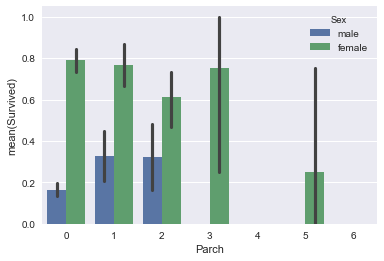

In [28]:
# Survival rates based on Parch

sns.barplot(x='Parch', y='Survived', hue='Sex', data=dt_train)

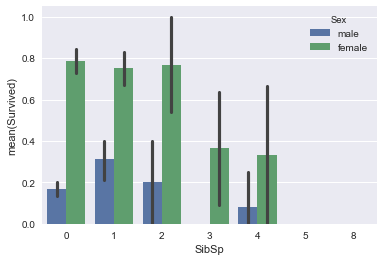

In [29]:
# Survival rates based on SibSp

sns.barplot(x='SibSp', y='Survived', hue='Sex', data=dt_train)

It seems as though survival rates go down for those with larger families on board. I'd bet this is because families didn't want to be separated, and larger families would've been less likely to get into the lifeboats all together. 

Since these tell a similar tale, we might want to combine them into a single variable describing simply the number of relatives on board:

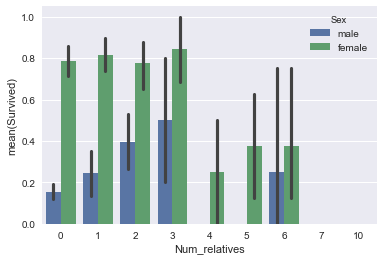

In [30]:
# Look at survival rates based on total number of relatives on board

dt_train['Num_relatives'] = dt_train.SibSp + dt_train.Parch
dt_test['Num_relatives'] = dt_test.SibSp + dt_test.Parch

sns.barplot(x='Num_relatives', y='Survived', hue='Sex', data=dt_train)

This is a lot more indicative for the men. Having 2 relatives on board doubles their survival odds vs. having none; having 3 relatives on board nearly triples them. 

For now, it will probably suffice to keep the combined column 'Num_relatives' and to drop SibSp and Parch. If we're not satisfied with our model later, we can revisit them and look for deeper patterns.

In [31]:
dt_train = dt_train.drop(['SibSp', 'Parch'], axis=1)
dt_test = dt_test.drop(['SibSp', 'Parch'], axis=1)

## <a name="ticket">Ticket</a>

In [32]:
dt_train.Ticket.unique()

array(['A/5 21171', 'PC 17599', 'STON/O2. 3101282', '113803', '373450',
       '330877', '17463', '349909', '347742', '237736', 'PP 9549',
       '113783', 'A/5. 2151', '347082', '350406', '248706', '382652',
       '244373', '345763', '2649', '239865', '248698', '330923', '113788',
       '347077', '2631', '19950', '330959', '349216', 'PC 17601',
       'PC 17569', '335677', 'C.A. 24579', 'PC 17604', '113789', '2677',
       'A./5. 2152', '345764', '2651', '7546', '11668', '349253',
       'SC/Paris 2123', '330958', 'S.C./A.4. 23567', '370371', '14311',
       '2662', '349237', '3101295', 'A/4. 39886', 'PC 17572', '2926',
       '113509', '19947', 'C.A. 31026', '2697', 'C.A. 34651', 'CA 2144',
       '2669', '113572', '36973', '347088', 'PC 17605', '2661',
       'C.A. 29395', 'S.P. 3464', '3101281', '315151', 'C.A. 33111',
       'S.O.C. 14879', '2680', '1601', '348123', '349208', '374746',
       '248738', '364516', '345767', '345779', '330932', '113059',
       'SO/C 14885', '31012

We can see that most ticket labels contained numbers only, but some contained letter prefixes of some sort. Let's separate the Ticket column into Ticket_prefix and Ticket_number columns. We can see above that ticket prefixes and ticket numbers are separated by white space, so we can exploit this.

In [33]:
dt_train['Ticket_number'] = dt_train.Ticket.apply(lambda x: x.split(' ')[-1])
dt_train['Ticket_prefix'] = dt_train.Ticket.apply(lambda x: x.split(' ')[0] if(len(x.split(' '))>1) else 'None' )

dt_test['Ticket_number'] = dt_test.Ticket.apply(lambda x: x.split(' ')[-1])
dt_test['Ticket_prefix'] = dt_test.Ticket.apply(lambda x: x.split(' ')[0] if(len(x.split(' '))>1) else 'None' )

In [34]:
dt_train.Ticket_prefix.value_counts()

None          665
PC             60
C.A.           27
STON/O         12
A/5            10
W./C.           9
SOTON/O.Q.      8
CA.             8
A/5.            7
SOTON/OQ        7
CA              6
STON/O2.        6
C               5
S.O.C.          5
SC/PARIS        5
F.C.C.          5
SC/Paris        4
S.O./P.P.       3
A/4.            3
PP              3
A/4             3
SC/AH           3
P/PP            2
S.C./PARIS      2
SOTON/O2        2
A.5.            2
WE/P            2
A./5.           2
A4.             1
S.O.P.          1
A/S             1
C.A./SOTON      1
SO/C            1
S.P.            1
W/C             1
S.C./A.4.       1
S.W./PP         1
F.C.            1
SCO/W           1
SC              1
W.E.P.          1
SW/PP           1
Fa              1
Name: Ticket_prefix, dtype: int64

Any correlations between ticket prefix and Pclass?

In [35]:
dt_train.groupby(['Pclass']).Ticket_prefix.value_counts()

Pclass  Ticket_prefix
1       None             152
        PC                60
        WE/P               2
        F.C.               1
        W.E.P.             1
2       None             127
        C.A.              19
        F.C.C.             5
        S.O.C.             5
        SC/PARIS           5
        SC/Paris           4
        SC/AH              3
        P/PP               2
        S.C./PARIS         2
        S.O./P.P.          2
        W./C.              2
        C.A./SOTON         1
        S.O.P.             1
        S.W./PP            1
        SC                 1
        SCO/W              1
        SO/C               1
        SW/PP              1
        W/C                1
3       None             386
        STON/O            12
        A/5               10
        C.A.               8
        CA.                8
        SOTON/O.Q.         8
        A/5.               7
        SOTON/OQ           7
        W./C.              7
        CA           

It would seem so.

Let's go ahead and drop the original 'Ticket' column:

In [36]:
dt_train = dt_train.drop(['Ticket'], axis=1)
dt_test = dt_test.drop(['Ticket'], axis=1)

Finally, I'd like to convert 'Ticket_number' from strings into integers, but there are a couple of values which read 'LINE':

In [37]:
dt_train.loc[(dt_train.Ticket_number=='LINE')]

,PassengerId,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Last_name,Name_prefix,Num_relatives,Ticket_number,Ticket_prefix
179,180,0,3,male,36.0,0.0,NaN,S,Leonard,Mr,0,LINE,None
271,272,1,3,male,25.0,0.0,NaN,S,Tornquist,Mr,0,LINE,None
302,303,0,3,male,19.0,0.0,NaN,S,Johnson,Mr,0,LINE,None
597,598,0,3,male,49.0,0.0,NaN,S,Johnson,Mr,0,LINE,None


We're just going to fudge these and assign a randomly chosen (by me) ticket number:

In [38]:
dt_train.set_value(179,'Ticket_number','3181');
dt_train.set_value(271,'Ticket_number','17894');
dt_train.set_value(302,'Ticket_number','2784');
dt_train.set_value(597,'Ticket_number','330921');

Now we'll convert the strings into integers:

In [39]:
dt_train.Ticket_number = dt_train.Ticket_number.apply(lambda x: int(x))
dt_test.Ticket_number = dt_test.Ticket_number.apply(lambda x: int(x))

## <a name="fare">Fare</a>

There is one NaN entry in 'Fare' in the test set. We'll simply fill it with the median fare in its Pclass.

In [40]:
dt_test.Fare = dt_test.groupby(['Pclass']).Fare.apply(lambda x: x.fillna( x.median())  )

In [41]:
sum(dt_test.Fare.isnull())

0

## <a name="cabin">Cabin</a>

There are significant number of empty/NaN entries in the Cabin column. We'll fill them in with 'U' to denote Unknown.

In [42]:
# Filling NaN values with 'U' 
dt_train.Cabin = dt_train.Cabin.fillna('U')
dt_test.Cabin = dt_test.Cabin.fillna('U')

Let's look at the unique cabin entries:

In [43]:
# Looking at the different cabin entries
dt_train.Cabin.unique()

array(['U', 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6', 'C23 C25 C27',
       'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33', 'F G73', 'E31',
       'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101', 'F E69', 'D47',
       'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4', 'A32', 'B4',
       'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35', 'C87', 'B77',
       'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19', 'B49', 'D',
       'C22 C26', 'C106', 'C65', 'E36', 'C54', 'B57 B59 B63 B66', 'C7',
       'E34', 'C32', 'B18', 'C124', 'C91', 'E40', 'T', 'C128', 'D37',
       'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44', 'A34', 'C104', 'C111',
       'C92', 'E38', 'D21', 'E12', 'E63', 'A14', 'B37', 'C30', 'D20',
       'B79', 'E25', 'D46', 'B73', 'C95', 'B38', 'B39', 'B22', 'C86',
       'C70', 'A16', 'C101', 'C68', 'A10', 'E68', 'B41', 'A20', 'D19',
       'D50', 'D9', 'A23', 'B50', 'A26', 'D48', 'E58', 'C126', 'B71',
       'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63', 'C62 C64', 'E24',

In [44]:
dt_test.Cabin.unique()

array(['U', 'B45', 'E31', 'B57 B59 B63 B66', 'B36', 'A21', 'C78', 'D34',
       'D19', 'A9', 'D15', 'C31', 'C23 C25 C27', 'F G63', 'B61', 'C53',
       'D43', 'C130', 'C132', 'C101', 'C55 C57', 'B71', 'C46', 'C116', 'F',
       'A29', 'G6', 'C6', 'C28', 'C51', 'E46', 'C54', 'C97', 'D22', 'B10',
       'F4', 'E45', 'E52', 'D30', 'B58 B60', 'E34', 'C62 C64', 'A11',
       'B11', 'C80', 'F33', 'C85', 'D37', 'C86', 'D21', 'C89', 'F E46',
       'A34', 'D', 'B26', 'C22 C26', 'B69', 'C32', 'B78', 'F E57', 'F2',
       'A18', 'C106', 'B51 B53 B55', 'D10 D12', 'E60', 'E50', 'E39 E41',
       'B52 B54 B56', 'C39', 'B24', 'D28', 'B41', 'C7', 'D40', 'D38',
       'C105'], dtype=object)

There are some odd entries here with multiple cabin inputs in a single entry, 
or what appear to be typos (i.e. 'F G63' instead of 'G63').
Perhaps some passengers had multiple cabins booked in their name?

In any case, we're going to clean this up and simply take the last-most cabin 
listed in each entry.

In [45]:
# clean up cabin assignments
dt_train.Cabin = dt_train.Cabin.apply(lambda x: x.split(' ')[-1])
dt_test.Cabin = dt_test.Cabin.apply(lambda x: x.split(' ')[-1])


Now, from having poked around the internet a bit, I've learned that 

1) The lifeboats on the Titanic were situated either towards the front or towards the back of the boat, with a gap in the middle (https://upload.wikimedia.org/wikipedia/commons/9/91/Titanic_Boat_Deck_plan_with_lifeboats.png).

2) The cabin number is more or less ascending as one goes to the back of the boat (https://www.encyclopedia-titanica.org/titanic-deckplans/)

One might suppose that front/back proximity to the lifeboats from each cabin might affect the survial outcome. However, due to the differences in deck layouts (i.e. decks A, B, C, etc), I can't really delinate this easily by cabin number.

The simplest thing to do for now is to take only the passengers' deck levels into account. We can come back to the cabin numbers later if we want.


In [46]:
# Take only deck level into account from 'Cabin'
# (i.e. the letter)

dt_train.Cabin = dt_train.Cabin.apply(lambda x: x[0])
dt_test.Cabin = dt_test.Cabin.apply(lambda x: x[0])

In [47]:
dt_train.Cabin.value_counts()

U    687
C     59
B     47
E     33
D     33
A     15
F      9
G      7
T      1
Name: Cabin, dtype: int64

In [48]:
dt_test.Cabin.value_counts()

U    327
C     35
B     18
D     13
E     11
A      7
F      5
G      2
Name: Cabin, dtype: int64

The significant number of U's is plain to see.

Can we spot any immediate relationships between cabin deck level and survival rates?

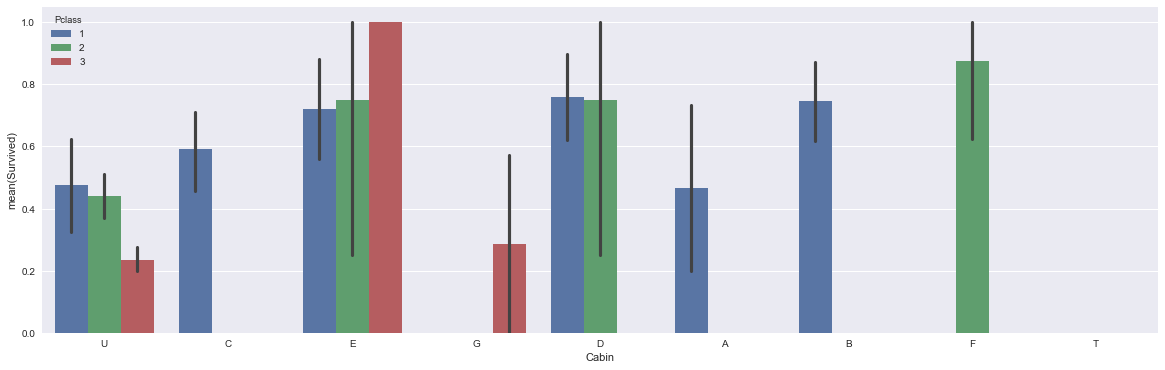

In [49]:
# Bar plots of survival by cabin and pclass

plt.subplots(1,1,figsize=(20,6))
sns.barplot(x='Cabin', y='Survived', hue='Pclass', data=dt_train)

For 1st and 2nd class passengers, the Unknown cabin entries basically average out in survival rate.

In [50]:
print(dt_train.groupby('Pclass').Cabin.value_counts())

Pclass  Cabin
1       C         59
        B         47
        U         40
        D         29
        E         25
        A         15
        T          1
2       U        168
        F          8
        D          4
        E          4
3       U        479
        G          7
        E          4
        F          1
Name: Cabin, dtype: int64


In [51]:
print(dt_test.groupby('Pclass').Cabin.value_counts())

Pclass  Cabin
1       C         35
        U         27
        B         18
        D         11
        E          9
        A          7
2       U         86
        F          5
        D          2
3       U        214
        E          2
        G          2
Name: Cabin, dtype: int64


A couple things:

Decks A, B, and C are exclusively 1st class. Deck D is primarily 1st class with some 2nd class overlap. 2nd and 3rd class folks almost exclusively fall into the Unknown cabin category. This implies that there is a decent degree of ordinality to the deck assignments, and that we can more or less treat 'U' as an extra bottom deck (i.e. instead of A-G we have A-G,U).

Note: There is a solitary 'T' cabin entry in the train set that needs to be dealt with ('T' was not a deck on the Titanic)

In [52]:
dt_train.loc[(dt_train.Cabin=='T')].Pclass

339    1
Name: Pclass, dtype: int64

Since 'C' was the most popular cabin among 1st class folks, we'll use it to replace the 'T' entry:

In [53]:
ind = dt_train.loc[(dt_train.Cabin=='T')].index
dt_train.set_value(ind,'Cabin','C');

## <a name="embarked">Embarked</a>

We'll simply replace the 2 NaN's in dt_train.Embarked by whatever value is most common:

In [54]:
dt_train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [55]:
# Replacing NaN's with 'S'
inds = dt_train.Embarked.loc[ (dt_train.Embarked.isnull() )].index
dt_train.set_value(inds, 'Embarked', 'S');

## <a name="encoding">Data encoding</a>

Now we need to encode our categorial string variables into integers, so that they can be run through classifier algorhithms. The columns in question are Sex, Cabin, Embarked, Last_name, Name_prefix, and Ticket_prefix:

In [56]:
dt_train.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Last_name,Name_prefix,Num_relatives,Ticket_number,Ticket_prefix
0,1,0,3,male,22.0,7.2500,U,S,Braund,Mr,1,21171,A/5
1,2,1,1,female,38.0,71.2833,C,C,Cumings,Mrs,1,17599,PC
2,3,1,3,female,26.0,7.9250,U,S,Heikkinen,Miss,0,3101282,STON/O2.
3,4,1,1,female,35.0,53.1000,C,S,Futrelle,Mrs,1,113803,None
4,5,0,3,male,35.0,8.0500,U,S,Allen,Mr,0,373450,None


As mentioned above, the Cabin variable has a degree of ordinality to it, so it will suffice to map the cabins A-G,U directly to integers (i.e. 1-8).

The remaining categorial variables are not ordinal (although Sex is binary, so it will suffice to let it be), so we'll do a one-hot encoding using pd.get_dummies . If this doesn't give us good results, we can consider more sophisticated encoding options (such as reducing dimensionality). To begin with, I'm going to leave out Last_name since this one column will obviously add the most dimensionality (and, I'm guessing, is of relatively lesser importance).

First we'll do the Cabin entries as mentioned:

In [57]:
cabinmap = {'A': 1, 'B':2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'U': 8}

dt_train.Cabin = dt_train.Cabin.apply(lambda x: cabinmap[x])
dt_test.Cabin = dt_test.Cabin.apply(lambda x: cabinmap[x])

In [58]:
dt_train.Cabin.head()

0    8
1    3
2    8
3    3
4    8
Name: Cabin, dtype: int64

Now let's go ahead and one-hot the data:

In [149]:
data = pd.concat([dt_train.drop(['Survived'], axis=1), dt_test])
features = ['Sex', 'Embarked', 'Name_prefix', 'Ticket_prefix']

oh = pd.get_dummies(data, columns=features)

oh_train = oh[0:890]
oh_train['Survived'] = dt_train.Survived
oh_test = oh[891:]

oh_train = oh_train.drop(['Last_name'], axis=1)
oh_test = oh_test.drop(['Last_name'], axis=1)

/Users/hayabusa/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [150]:
oh_train.head()

,PassengerId,Pclass,Age,Fare,Cabin,Num_relatives,Ticket_number,Sex_female,Sex_male,Embarked_C,...,Ticket_prefix_SOTON/OQ,Ticket_prefix_STON/O,Ticket_prefix_STON/O2.,Ticket_prefix_STON/OQ.,Ticket_prefix_SW/PP,Ticket_prefix_W./C.,Ticket_prefix_W.E.P.,Ticket_prefix_W/C,Ticket_prefix_WE/P,Survived
0,1,3,22.0,7.2500,8,1,21171,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,38.0,71.2833,3,1,17599,1,0,1,...,0,0,0,0,0,0,0,0,0,1
2,3,3,26.0,7.9250,8,0,3101282,1,0,0,...,0,0,1,0,0,0,0,0,0,1
3,4,1,35.0,53.1000,3,1,113803,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,5,3,35.0,8.0500,8,0,373450,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [151]:
oh_test.head()

,PassengerId,Pclass,Age,Fare,Cabin,Num_relatives,Ticket_number,Sex_female,Sex_male,Embarked_C,...,Ticket_prefix_SOTON/O2,Ticket_prefix_SOTON/OQ,Ticket_prefix_STON/O,Ticket_prefix_STON/O2.,Ticket_prefix_STON/OQ.,Ticket_prefix_SW/PP,Ticket_prefix_W./C.,Ticket_prefix_W.E.P.,Ticket_prefix_W/C,Ticket_prefix_WE/P
0,892,3,34.5,7.8292,8,0,330911,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,893,3,47.0,7.0000,8,1,363272,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,894,2,62.0,9.6875,8,0,240276,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,895,3,27.0,8.6625,8,0,315154,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,896,3,22.0,12.2875,8,2,3101298,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## <a name="modeling">Model training</a>

Let's import a Random Forest classifier and some metrics:

In [152]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score

We'll do Grid Search CV to try a range of parameters for the classifier in order to find the best ones. For now, I'll use a wide range of parameters which will take my computer an hour or two to work through:

Now define an 80/20 train/test split on our training data:

In [153]:
from sklearn.model_selection import train_test_split

X = oh_train.drop(['PassengerId', 'Survived'], axis=1)
Y = oh_train.Survived

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Now we'll set up K-Fold cross-validation with 10 folds:

In [154]:
from sklearn.cross_validation import KFold

def run_kfold(clf):
    
    kf = KFold(len(X), n_folds=10)
    outcomes = []
    fold = 1
    
    for train_index, test_index in kf:
        x_train_kf, x_test_kf = X.values[train_index], X.values[test_index]
        y_train_kf, y_test_kf = Y.values[train_index], Y.values[test_index]
        
        clf.fit(x_train_kf, y_train_kf)
        predictions = clf.predict(x_test_kf)
        acc = accuracy_score(y_test_kf, predictions)
        
        outcomes.append(acc)
        print("Fold %s, Accuracy = %s" % (fold, acc))
        fold += 1
        
    mean_accuracy = np.mean(outcomes)
    std_dev = np.std(outcomes)
    print("*** Mean Accuracy = %s" % mean_accuracy)
    print("*** Std Dev = %s" % std_dev)    

And now the (initial) moment of truth: we'll tune the classifier with GridSearchCV, fit it to our 80% training data, and test it on our 20% withheld training data. 

In [155]:
clf = RandomForestClassifier()

# some params to try:
parameters = {'n_estimators': [10, 50, 100, 200, 250], 
                  'max_features': [None, 'log2', 'sqrt','auto'], 
                  'criterion': ['entropy', 'gini'],
                  'max_depth': [2, 4, 7, 18, 23, 30], 
                  'min_samples_split': [2, 3, 5, 7, 12, 50],
                  'min_samples_leaf': [1,3,5,8,13],
                  'min_weight_fraction_leaf' : [0.0, 0.2],
                  'max_leaf_nodes' : [None, 5,12,18,24],              
                 }


# Run GridSearchCV on the classifier
accuracy = make_scorer(accuracy_score)
    
grid = GridSearchCV(clf, parameters, scoring=accuracy)
grid = grid.fit(x_train, y_train)

clf = grid.best_estimator_
clf.fit(x_train, y_train)

run_kfold(clf)

Fold 1, Accuracy = 0.808988764045
Fold 2, Accuracy = 0.842696629213
Fold 3, Accuracy = 0.797752808989
Fold 4, Accuracy = 0.842696629213
Fold 5, Accuracy = 0.887640449438
Fold 6, Accuracy = 0.85393258427
Fold 7, Accuracy = 0.797752808989
Fold 8, Accuracy = 0.831460674157
Fold 9, Accuracy = 0.865168539326
Fold 10, Accuracy = 0.876404494382
*** Mean Accuracy = 0.840449438202
*** Std Dev = 0.0300653666523


In [196]:
clf 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=7, max_features=None, max_leaf_nodes=24,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

Our trained classifier (For future reference, so we don't have to re-fit again later) came out to be:

This gave us a mean accuracy of 0.84 on k-fold.

What were the relative weights of all the data features in the trained classifier?

In [201]:
clf.fit(x_train, y_train)

for w in range(x_train.shape[1]):
    print('%d. %s (%f)' % (w + 1,  x_train.columns[indices[w]], clf.feature_importances_[indices[w]]))

1. Ticket_number (0.140333)
2. Fare (0.101430)
3. Age (0.090610)
4. Sex_female (0.093018)
5. Name_prefix_Mr (0.182825)
6. Sex_male (0.093187)
7. Num_relatives (0.052592)
8. Pclass (0.113698)
9. Cabin (0.077130)
10. Name_prefix_Miss (0.002567)
11. Name_prefix_Mrs (0.002526)
12. Ticket_prefix_None (0.007015)
13. Embarked_S (0.008422)
14. Embarked_C (0.002020)
15. Name_prefix_Master (0.001724)
16. Embarked_Q (0.003045)
17. Ticket_prefix_PC (0.001089)
18. Ticket_prefix_STON/O (0.011540)
19. Ticket_prefix_C.A. (0.000000)
20. Ticket_prefix_A/5. (0.000051)
21. Name_prefix_RevDr (0.015026)
22. Ticket_prefix_W./C. (0.000000)
23. Ticket_prefix_CA. (0.000000)
24. Ticket_prefix_S.W./PP (0.000000)
25. Ticket_prefix_CA (0.000000)
26. Ticket_prefix_SOTON/O.Q. (0.000000)
27. Ticket_prefix_C (0.000000)
28. Ticket_prefix_SW/PP (0.000000)
29. Ticket_prefix_S.O./P.P. (0.000000)
30. Name_prefix_Officer (0.000000)
31. Ticket_prefix_STON/O2. (0.000000)
32. Ticket_prefix_S.O.C. (0.000000)
33. Ticket_prefix_A/

I am skeptical that Ticket_number is actually the strongest feature. We will try dropping this column and repeating the fitting:

In [204]:
X = oh_train.drop(['PassengerId', 'Survived', 'Ticket_number'], axis=1)
Y = oh_train.Survived

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=43)

### 
clf = RandomForestClassifier()

# some params to try:
parameters = {'n_estimators': [10, 50, 100, 200, 250], 
                  'max_features': [None, 'log2', 'sqrt','auto'], 
                  'criterion': ['entropy', 'gini'],
                  'max_depth': [2, 4, 7, 18, 23, 30], 
                  'min_samples_split': [2, 3, 5, 7, 12, 50],
                  'min_samples_leaf': [1,3,5,8,13],
                  'min_weight_fraction_leaf' : [0.0, 0.2],
                  'max_leaf_nodes' : [None, 5,12,18,24],              
                 }


# Run GridSearchCV on the classifier
accuracy = make_scorer(accuracy_score)
    
grid = GridSearchCV(clf, parameters, scoring=accuracy)
grid = grid.fit(x_train, y_train)

clf = grid.best_estimator_
clf.fit(x_train, y_train)

run_kfold(clf)

Fold 1, Accuracy = 0.808988764045
Fold 2, Accuracy = 0.85393258427
Fold 3, Accuracy = 0.775280898876
Fold 4, Accuracy = 0.797752808989
Fold 5, Accuracy = 0.831460674157
Fold 6, Accuracy = 0.842696629213
Fold 7, Accuracy = 0.808988764045
Fold 8, Accuracy = 0.775280898876
Fold 9, Accuracy = 0.876404494382
Fold 10, Accuracy = 0.831460674157
*** Mean Accuracy = 0.820224719101
*** Std Dev = 0.0313803147051


In [205]:
clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=23, max_features='auto', max_leaf_nodes=24,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=3, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [210]:
clf.fit(x_train, y_train)

for w in range(x_train.shape[1]):
    print('%d. %s (%f)' % (w + 1,  x_train.columns[indices[w]], clf.feature_importances_[indices[w]]))

1. Sex_female (0.147252)
2. Fare (0.143126)
3. Age (0.040791)
4. Sex_male (0.076909)
5. Name_prefix_Mrs (0.010058)
6. Embarked_C (0.004753)
7. Num_relatives (0.076236)
8. Pclass (0.093220)
9. Cabin (0.055447)
10. Name_prefix_Mr (0.206398)
11. Name_prefix_NobleF (0.000000)
12. Ticket_prefix_P/PP (0.000000)
13. Name_prefix_Master (0.020713)
14. Embarked_Q (0.004623)
15. Name_prefix_Miss (0.037457)
16. Embarked_S (0.013536)
17. Ticket_prefix_PP (0.000000)
18. Ticket_prefix_STON/O2. (0.003323)
19. Ticket_prefix_C.A./SOTON (0.000000)
20. Ticket_prefix_A/S (0.000000)
21. Ticket_prefix_A. (0.000000)
22. Ticket_prefix_W.E.P. (0.000000)
23. Ticket_prefix_F.C. (0.000000)
24. Ticket_prefix_SC (0.000000)
25. Ticket_prefix_CA. (0.006104)
26. Ticket_prefix_SOTON/O2 (0.000000)
27. Ticket_prefix_C.A. (0.005451)
28. Ticket_prefix_W./C. (0.001817)
29. Ticket_prefix_S.O.C. (0.002941)
30. Name_prefix_RevDr (0.001350)
31. Ticket_prefix_STON/OQ. (0.000000)
32. Ticket_prefix_S.O.P. (0.001878)
33. Ticket_pref

IndexError: index 68 is out of bounds for axis 0 with size 68

These feature importance rankings are more in line with what I would expect, but the k-fold scores aren't as good. I'm going to run both of these trained classifiers on their respective test sets (i.e. with and without 'Ticket_number'), and see how the results score on Kaggle.

In [208]:
# With Ticket_number

X = oh_train.drop(['PassengerId', 'Survived'], axis=1)
Y = oh_train.Survived

clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy', max_depth=7, max_features=None, max_leaf_nodes=24, min_impurity_split=1e-07, min_samples_leaf=5, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1, oob_score=False, random_state=None, verbose=0, warm_start=False)

clf.fit(X,Y)

print("")
print(" *** Outputting test results as .csv ***")    
ids = oh_test.PassengerId
preds = clf.predict(oh_test.drop(['PassengerId'], axis=1))
    
output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': preds })
output.to_csv('titanic_predictions.csv', index = False)



 *** Outputting test results as .csv ***


In [211]:
# Without 'Ticket_number'

X = oh_train.drop(['PassengerId', 'Survived','Ticket_number'], axis=1)
Y = oh_train.Survived

clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=23, max_features='auto', max_leaf_nodes=24,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=3, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

clf.fit(X,Y)

print("")
print(" *** Outputting test results as .csv ***")    
ids = oh_test.PassengerId
preds = clf.predict(oh_test.drop(['PassengerId', 'Ticket_number'], axis=1))
    
output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': preds })
output.to_csv('titanic_predictions.csv', index = False)



 *** Outputting test results as .csv ***


Sure enough: the former scored 0.78468, good for a leaderboard placement of 4139 (out of ~9200), whereas the latter scored 0.80382, which ranks 1150 on the leaderboard (i.e. top 15%). It can be beneficial sometimes to trust your gut.